# Práctico 1: Clustering - Text Mining 2021

Notebook sobre el práctico 1 de la materia Mineria de Texto para Datos, materia correspondiente de la carrera Lic. En Ciencias de la Computación de FaMAF, UNC.

Estudiante: Garagiola Nazareno


Clustering es el proceso de agrupar un conjunto de elementos (en este caso de palabras) que tengan similitudes.
Hipotesis de Clustering: Palabras en el mismo cluster, tienen un comportamiento similar con respecto a la informacion que contienen.

---
## Requerimientos

Instalamos las librerias necesarias para el procesamiento.

In [225]:
#!python3 -m spacy download es_core_news_md > trash.txt

In [226]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

---
## Carga del Corpus

Leemos el corpus a estudiar, hacemos algunos reemplazos para correjir un poco el texto.

Tomamos los primeros 0.5 M - 2 caracteres (ese numero ya que coincide con el fin de un parrafo).

In [227]:
f = open("lavoztextodump.txt", 'r')
text = f.read()[:1000000] #[:500000-2] #
text = text.replace('"', '')
text = text.replace('-\n', '\n')
text = text.replace('&#','')
#text = text.replace('á','a')
#text = text.replace('é','e')
#text = text.replace('í','i')
#text = text.replace('ó','o')
#text = text.replace('ú','u')


Cargamos el texto usando [Spacy](https://spacy.io/), tomamos los lemmas del texto y las palabras que aparezcan. Luego, hago un conteo de la cantidad de lemmas que aparecieron en el documento.

In [228]:
nlp = spacy.load("es_core_news_md", vectores=False, entity=False)

lemmas = []
words = []
doc = nlp(text)
for token in doc:
    if len(token) > 1 and token.is_alpha:
        lemmas.append(token.lemma_.lower())
        words.append(token.text)

counter_lemma = Counter(lemmas)

Si están trabajando en Colab, es normal que al hacer el load de Spacy aparezca un error.

**`ModuleNotFoundError: No module named 'es_core_news_md'`**.

Reinicien el Kernel/Runtime (usen el menú de arriba Runtime->restart runtime) y salteen la celda de instalación (la primera que dice lo de abajo).

    !python3 -m spacy download es_core_news_md > trash.txt


---
## Preprocesamiento

Definimos algunas funciones que nos van a servir para poder filtrar palabras y poder seleccionar que palabras del documento vamos a analizar. Luego cargamos diccionarios con las caracteristicas de cada palabra que serviran para poder vectorizar estos lemmas.
En la variable MIN_FREQ especificamos la cantidad minima de veces que queremos que aparezca cada lemma a estudiar. 

In [229]:
MIN_FREQ = 50

def word_filter(token):
    """
    Pequeña funcion que usaremos para filtrar las palabras
    """
    return (not token.is_alpha) or (token.is_digit) or counter_lemma[token.lemma_] < MIN_FREQ 

with open("stopwords.txt",'r') as s:
    stopwords = s.read().split('\n')

def not_a_stopword(token):
    """
    Funcion que toma un token de Spacy y revisa que su lemma sea o on una 
    stopword en español
    """
    return (token.is_alpha and (not token.lemma_.lower() in stopwords))


def immediate_related_words(span):
    """
    Funcion que a partir de un Span (parte continua del doc) retorna una lista
    con los lemmas de las palabras que no sean stopwords
    """
    tokens = list(filter(not_a_stopword, span))
    return list(map(lambda token: token.lemma_, tokens))

def keywords_in(span):
    """
    Funcion que a partir de un Span, retorna una lista con los lemmas de las 
    palabras del span que no sean stopwords ni tampoco no sean relevantes.
    (la funcion )
    """
    tokens = list(filter(
        lambda token: not word_filter(token) and not_a_stopword(token), span))
    return list(map(lambda token: token.lemma_, tokens))


Creo diccionarios para cada una de las caracteristicas y los inicializo para cada lemma que pasan el filtro.

* Part of Speech
* Dependencias
* Contexto cercano sin stopwords
* Contexto mayor, con palabras claves
* Triplas de dependencias
* Si tiene o no un numero detras, para indicar que es contable.

In [230]:
def init_feats():
    for token in doc:
        if word_filter(token): continue
        word = token.lemma_.lower()
        triplas[word] = {}
        tag[word] = {}
        pos[word] = {}
        close_context[word] = {}
        large_context[word] = {}
        countable[word] = {}

Cargo cada diccionario para cada palabra que pasa el filtro, con las caracteristicas que seleccionamos.

Definimos dos variables para el tamaño de ventana de los dos contextos que tomamos, el inmediato y el mayor.



In [231]:
def load_feats(close_window = 2, large_window = 15):
    for token in doc:
        if word_filter(token): continue

        i = token.i
        word = token.lemma_.lower()
        # Cargo part of speech de cada palabra lematizada
        if not token.pos_ in pos[word].keys():
            pos[word][token.pos_] = 0
        pos[word][token.pos_] += 1

        # Cargo tag de cada palabra lematizada
        if not token.tag_ in tag[word].keys():
            tag[word][token.tag_] = 0
        tag[word][token.tag_] += 1

        #Triplas de dependencias. Notar que busco el root de la frase en la que la 
        #palabra siguiente este, y esta puede no necesariamente estar en mis palabras
        #claves que superan el filtro.
        if not i == len(doc) - 1:
            #NOTAR: se usa token.text y no el lemma_, porque me interesa como aparece la instancia del lemma,
            #no como es usado.
            tripla = (f"obj: {token.text} - dep : {token.dep_} - root: {doc[i+1].head.lemma_}")
            if not tripla in triplas[word].keys():
                triplas[word][tripla] = 0
            triplas[word][tripla] += 1

        if i > 0 and doc[i-1].is_digit:
            if not 'counts' in countable[word].keys():
                countable[word]['counts'] = 0
            countable[word]['counts'] += 1

        #contexto inmediato, con una ventana 1 de distancia, sin stopwords
        close_lft, close_rgt = i-close_window, i+close_window
        if not (close_lft <= 0 and close_rgt >= len(doc)):

            imm_related_words = immediate_related_words(doc[close_lft:close_rgt]) if not token.is_sent_start else immediate_related_words(doc[i:close_rgt])

            #imm_related_words = immediate_related_words(doc[close_lft:close_rgt])
            for w in imm_related_words:
                if w == word: continue
                if not w in close_context[word].keys():
                    close_context[word][w] = 0
                close_context[word][w] += 1

        #contexto mas grande, solo de las palabras que me interesan y sin stopwords
        large_lft, large_rgt = i-large_window, i+large_window
        if not (large_lft <= 0 and large_rgt >= len(doc)):

            keywords_in_context = keywords_in(doc[large_lft: large_rgt]) if not token.is_sent_start else keywords_in(doc[i: large_rgt])
            
            for w in keywords_in_context:
                if w == word: continue
                if not w in large_context[word].keys():
                    large_context[word][w] = 0
                large_context[word][w] += 1


Cargamos todas las caracteristicas que recogimos y las agrupamos en un nuevo diccionario cuyas claves tambien son las palabras lematizadas que analizamos.

In [232]:
def group_feats():
    feats = {}
    for token in doc:
        if word_filter(token): continue
        word = token.lemma_
        feats[word] = {**tag[word], **pos[word], **triplas[word], **large_context[word], **close_context[word], **countable[word]}
    return feats

---
## Vectorización

Luego del pre-procesamiento, tenemos un diccionario de la forma {"palabra":"caracteristicas"}. A este le removemos las claves e ingresamos las caracteristicas (que son un diccionario) a un arreglo, el cual [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) lo transformara en una matriz, con filas que representan las palabras y en cada columna un valor para cada caracteristica.

In [233]:
from sklearn.feature_extraction import DictVectorizer
def vectorize(feats):
    vectorizer = DictVectorizer(sparse=False)
    features, key_words, wid = [], {}, 0
    for word in feats:
        key_words[word] = wid
        wid += 1
        features.append(feats[word])
    matrix = vectorizer.fit_transform(X=features)
    return matrix, key_words, wid

Ahora debemos normalizar la matriz (es decir, que los vectores tengan valores en el intervalo [0,1] y con norma 1).

Usamos [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), otra herramienta de sklearn para poder reducir la dimensionalidad de la matrix y descartar aquellos valores que tengan poca varianza, es decir caracteristicas que no varien mucho entre las palabras.

El valor VARIANCE_THRESHOLD es definido por el usuario

In [234]:
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-8
def transform(matrix):
    selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
    normed_matrix = normalize(matrix, axis=1, norm='l1')
    reduced_matrix = selector.fit_transform(normed_matrix)
    print(f"Tamaño original: {normed_matrix.shape}. Tamaño reducido: {reduced_matrix.shape}")
    return normed_matrix, reduced_matrix

---
## Clustering

Una vez que ya tenemos nuestra matriz de caracteristicas como vectores normalizada y reducida, la usamos para alimentar la funcion que nos arma los clusters. 

Usamos las implementaciones de [nltk](https://tedboy.github.io/nlps/generated/generated/nltk.cluster.KMeansClusterer.html) y sklearn: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

En la version de ntlk, usamos la distancia coseno, y en la version de sklearn usamos distancia euclidea, como los valores de la matriz se encuentran normalizados, son muy similares ambos metodos.


In [235]:
from nltk.cluster import kmeans, cosine_distance

def ntlk_clustering(k, matrix):
    clusterer = kmeans.KMeansClusterer(num_means=k, distance=cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix, assign_clusters=True)
    return clusters

from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(X=matrix)
    return clusterer.labels_

---
## Dimensionalidad y Embeddings

Para aplicar Embeddings uso las implementaciones de LSA y de t-sne que posee sklearn [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) y [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Con la primera, hago reducción a 100 dimensiones y con t-sne reduzco a dos dimensiones, para poder visualizar los clusters.


In [236]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def tsne_reduction(matrix):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_data = tsne.fit_transform(matrix)
    return tsne_data

def lsa_reduction(n_comp, matrix):
    svd = TruncatedSVD(n_components=n_comp)
    lsa_data = svd.fit_transform(X=matrix)
    return lsa_data

---
## Uso

In [237]:
triplas = {}
tag = {}
pos = {}
close_context = {}
large_context = {}
countable = {}

init_feats()
load_feats(2,7)
feats = group_feats()

matrix, key_words, wid = vectorize(feats)
normed_matrix, reduced_matrix = transform(matrix)

NUM_CLUSTERS = 30
ntlk_cluster =  ntlk_clustering(NUM_CLUSTERS, reduced_matrix)
sk_cluster = sklearn_clustering(NUM_CLUSTERS, reduced_matrix)

Tamaño original: (340, 65737). Tamaño reducido: (340, 18434)


In [238]:
tsne_data = tsne_reduction(normed_matrix)
lsa_data = lsa_reduction(200, normed_matrix)

print(lsa_data.shape, tsne_data.shape, normed_matrix.shape)

(340, 200) (340, 2) (340, 65737)


In [239]:
data = [(tsne_data[i], ntlk_cluster[i], list(key_words.keys())[i]) for i in range(wid)]
df_clustered = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in data],
    columns=["dim1", "dim2", "cluster", "word"]
)

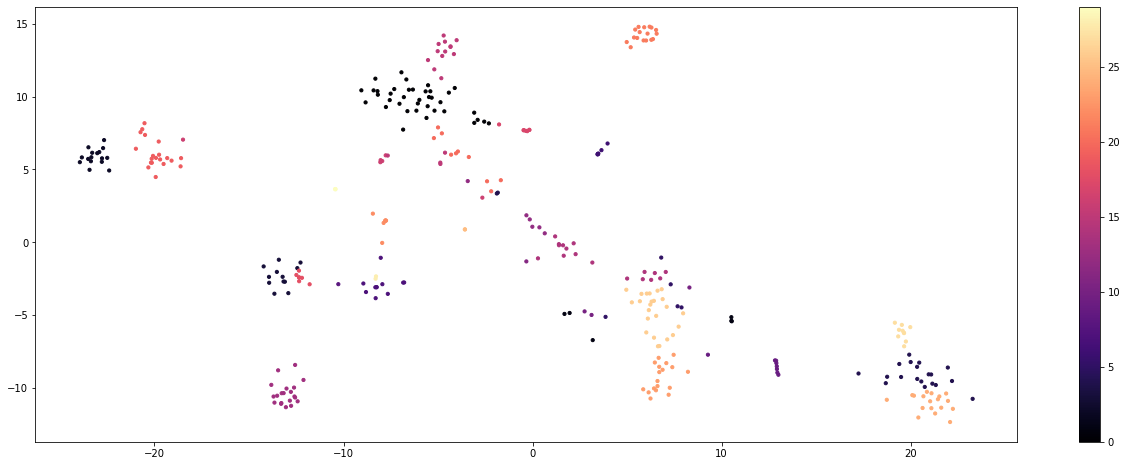

In [240]:
plt.figure(figsize=(22, 8))
g = plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=10, c=df_clustered['cluster'], cmap='magma', alpha=1)
plt.colorbar(g)
plt.show()

---
##Resultados

In [242]:
def plot_cluster_of(word, cluster_name=ntlk_cluster):
    df = df_clustered[df_clustered['cluster']==cluster_name[key_words[word]]]
    plt.figure(figsize=(12, 5))
    h = plt.scatter(x=df['dim1'],y=df['dim2'], s=10, c=df['cluster'], cmap='magma', alpha=1)
    for i in range(wid):
        if df_clustered['cluster'][i] == cluster_name[key_words[word]]:
            plt.annotate(df['word'][i], (df['dim1'][i], df['dim2'][i]))
    plt.show()

In [241]:
def get_clusters(close_w, large_w, k, clustering=ntlk_clustering):
    """
    Funcion que usamos para poder testear los resultados, toma como parametros a
    los parametros de las funciones internas, es decir, los tamaños de ventana 
    para los contextos, la cantidad de clusters y el algoritmo de clustering.
    """
    triplas = {}
    tag = {}
    pos = {}
    close_context = {}
    large_context = {}
    countable = {}

    init_feats()
    load_feats(close_w,large_w)
    feats = group_feats()

    matrix, key_words, wid = vectorize(feats)
    normed_matrix, reduced_matrix = transform(matrix)
    
    return clustering(k, reduced_matrix)

In [243]:
def show_clusters(k, cluster_name=ntlk_cluster):
    for i in range(k):
        c = [token for token in key_words if cluster_name[key_words[token]]==i]
        print(f"Cluster {i}:\n {c}")

In [244]:
def cluster_of(word, cluster_name=ntlk_cluster):
    c = [token for token in key_words if cluster_name[key_words[token]]==cluster_name[key_words[word]]]
    return c

In [245]:
def same_cluster(word1, word2, cluster_name=ntlk_cluster):
    return cluster_name[key_words[word1]]==cluster_name[key_words[word2]]

---
Los clusterings que mejor resultado dieron y tambien el clustering a partir de la matriz resultado de aplicar LSA.


In [246]:
clusters_1_7 = get_clusters(1,7,40)
clusters_2_7 = get_clusters(2,7,40)
clusters_3_15 = get_clusters(3,15,40)
lsa_cluster =  ntlk_clustering(40, lsa_data)

Tamaño original: (340, 62530). Tamaño reducido: (340, 16934)
Tamaño original: (340, 65737). Tamaño reducido: (340, 18434)
Tamaño original: (340, 66537). Tamaño reducido: (340, 15136)


---
Primero es una celda para poder testear algunos resultados, tomando aleatoriamente pares de palabras y revisando si caen dentro del mismo cluster. Podemos verificar si nuestro modelo funciona bien manualmente.

In [247]:
from random import randint
words = list(key_words.keys())
n = len(words)
test_amount = 10

for i in range(test_amount):
    U, V = randint(0,n-1), randint(0,n-1)
    w1, w2 = words[U], words[V]
    print(f"{w1} & {w2}: {same_cluster(w1, w2)}")

alumno & secundario: False
dejar & más: False
parecer & qué: False
tratar & interior: False
mundo & nacional: False
no & local: False
elegir & pero: False
fondo & realizar: False
durante & por: True
voto & mundo: False


Con un arreglo de palabras que seleccione, verificamos algunos resultados de los diferentes clusters.

In [248]:
test_words = ['el', 'él', 'policía', 'peso', 'escuela', 'mil', 'intendente', 'que', 'mujer', 'ley', 'lograr', 'año']
results_ntlk = {}
results_lsa = {}
for tw in test_words:
    results_ntlk[tw] = cluster_of(tw, ntlk_cluster)
    results_lsa[tw] = cluster_of(tw, lsa_cluster)

['estudiante', 'joven', 'docente', 'dirigente', 'peso', 'intendente', 'juez', 'policía'] 
 ['intendente', 'juez', 'policía']


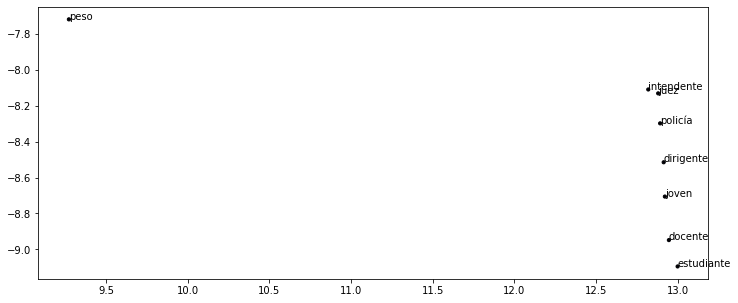

In [249]:
#empleos
print(results_ntlk["intendente"],"\n",results_lsa["intendente"])
plot_cluster_of('intendente')

['cuatro', 'do', 'tres', 'cincar', 'mil', 'ciento', 'seis'] 
 ['cuatro', 'do', 'tres', 'cincar', 'mil', 'ciento', 'seis']


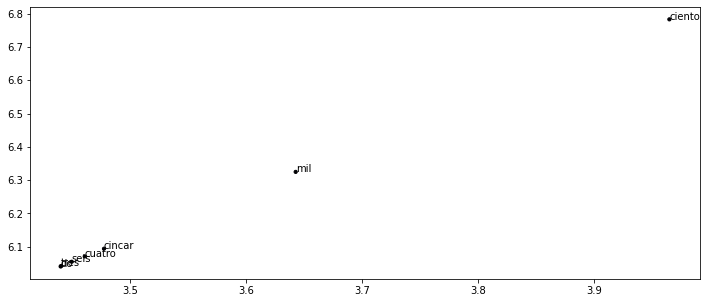

In [250]:
#numeros
print(results_ntlk["mil"],"\n",results_lsa["mil"])
plot_cluster_of('mil')

['tener', 'conocer', 'llevar', 'lograr', 'querer', 'hablar', 'hacer', 'vivir', 'seguir', 'ver', 'ganar', 'tratar', 'elegir', 'dejar', 'poner', 'mantener', 'decidir', 'sumar', 'saber', 'llegar', 'dar', 'venir', 'creer', 'esperar', 'participar', 'generar', 'mostrar', 'comenzar', 'cumplir', 'recibir', 'incluir', 'realizar', 'existir', 'permitir', 'terminar', 'plantear', 'presentar', 'producir'] 
 ['conocer', 'llevar', 'lograr', 'hablar', 'ver', 'ganar', 'elegir', 'poner', 'decidir', 'llegar', 'dar', 'salir', 'quedar', 'participar', 'mostrar', 'cumplir', 'encontrar', 'recibir', 'realizar', 'terminar', 'pagar', 'plantear', 'viajar', 'caer', 'presentar', 'producir']


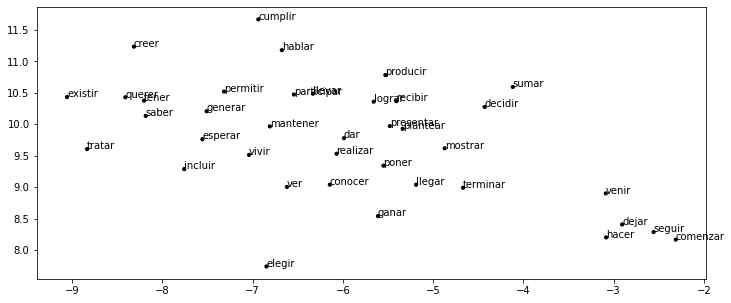

In [251]:
#verbos
print(results_ntlk["lograr"],"\n",results_lsa["lograr"])
plot_cluster_of('lograr')

['lo', 'el', 'uno', 'los', 'ese', 'cada', 'su', 'este', 'distinto', 'nuestro', 'vario', 'mi'] 
 ['lo', 'el', 'otro', 'uno', 'los', 'todo', 'mismo', 'ese', 'ninguno', 'cada', 'alguno', 'su', 'este', 'mucho', 'distinto', 'nuestro', 'vario', 'mi', 'propio']


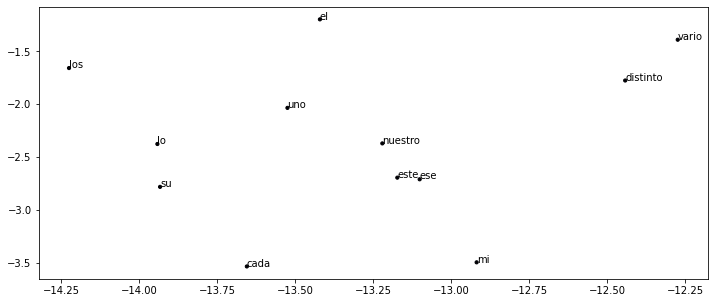

In [252]:
#stopwords1
print(results_ntlk["el"],"\n",results_lsa["el"])
plot_cluster_of('el')

['se', 'unir', 'les', 'me', 'nadar', 'le', 'ellos', 'donde', 'él', 'cómo', 'algo'] 
 ['se', 'unir', 'les', 'me', 'nadar', 'qué', 'le', 'ellos', 'donde', 'quien', 'él', 'cómo', 'cual', 'algo']


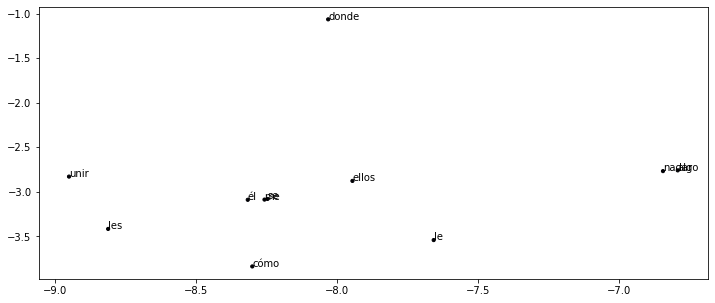

In [253]:
#stopwords2
print(results_ntlk["él"],"\n",results_lsa["él"])
plot_cluster_of('él')